In [3]:
############ LOAD in custom packages ################
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
import json

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier
from catboost import Pool
import catboost as cb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from itertools import product,chain

import plotly.express as px



# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add project root to sys.path
sys.path.append(project_root)
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data')

# Import and reload my custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
from scripts import feature_selection as fs
from scripts import clustering as cl
importlib.reload(pre)
importlib.reload(vis)
importlib.reload(fs)
importlib.reload(cl)

# Import from cloned github repos
import hyperopt
print(hyperopt.__file__)
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
import hyperopt.pyll.stochastic
################ DEFINE column variables from data ###################
from scripts.variables import id_columns, daily_cols_v1, daily_v2_common 
from scripts.variables import phq2_cols, phq9_cols, weekly_cols, passive_cols, survey_cols


## Load in dfs scaled
df_names = ['v1_day', 'v2_day', 'v1_week']
df_pca = ['v1_day_pca', 'v1_week_pca']
df_all = df_names + df_pca

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/git_repos/hyperopt_repo/hyperopt/__init__.py


In [5]:
#### Simple linear regression
from sklearn.linear_model import LinearRegression
# Step 1: Set x_cols to the various V1 PCs
y_var = 'pc_depression_phq2'
data = pd.read_csv(os.path.join(brighten_dir, 'v1_day_pca.csv'))
#print(data.columns.to_list())
results = pd.DataFrame()
count=0
x_cols = [col for col in data.columns.to_list() if 'pc_' in col and col!=y_var]
y_col = [y_var]

reg = LinearRegression().fit(data[x_cols], data[y_col])
print(reg.score(data[x_cols], data[y_col]))
print(reg.coef_)
print(reg.intercept_)

0.0032143094652498094
[[0.00429332 0.00113432 0.09436832]]
[0.0440816]


In [9]:
######### Mixed LM Model V1 vs phq2_sum #########
###### V1 PCs vs phq2_sum #########
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.api as sm
import statsmodels.formula.api as smf

ignore_cols = ['num_id', 'dt', 'week', 'day']
y_var = 'phq9_sum'
data = pd.read_csv(os.path.join(brighten_dir, 'v1_week_imp.csv'))
results = pd.DataFrame()
count = 0
x_cols = [col for col in data.columns.to_list() if 'phq9' not in col and col not in ignore_cols]
data_full = data[x_cols + [y_var, 'num_id']].copy().dropna()
data_full["num_id"] = data_full["num_id"].astype("category")
display(data_full)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

model = smf.mixedlm(f"{y_var} ~ mobility  + sms_count + unreturned_calls + phq2_sum", 
                    data=data_full, 
                    groups=data_full["num_id"])
result = model.fit()
print(f'Relationship to y_col {y_var}, Nested Linear Regression on "num_id"')
print(result.summary())



,Unnamed: 0,mobility,mobility_radius,gender,age,aggregate_communication,call_count,interaction_diversity,missed_interactions,sms_count,unreturned_calls,phq2_1,phq2_2,phq2_sum,phq9_sum,num_id
0,0,-1.922677,-0.844628,-0.607847,0.047498,-0.307222,-0.951653,-1.052668,-0.491618,-0.079512,-0.409568,-0.053653,-0.063443,-0.036595,0.484128,21.0
3,3,1.206361,0.807768,-0.607847,-1.467091,1.121347,-0.768855,-0.231999,-1.084741,1.197651,-0.861808,0.301431,-0.252726,0.056274,0.484128,22.0
4,4,-0.259382,0.046046,-0.607847,-1.467091,0.810392,-0.213791,-0.231999,-1.161496,0.900872,-1.253555,-0.390953,-0.536673,-0.473189,0.360830,22.0
5,5,-0.302232,-1.224821,-0.607847,-0.775707,0.823721,0.180032,0.167011,1.218648,0.891035,0.779964,-0.053653,-0.063443,-0.036595,0.700237,25.0
6,6,0.330737,-0.208479,-0.607847,-0.775707,0.875321,1.781806,1.056433,0.135854,0.728100,-0.861808,0.128563,0.115603,0.146194,0.224530,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,1018,0.157073,-0.507615,-0.607847,-1.795339,0.232296,-0.024670,0.957066,1.647698,0.299811,2.236386,-0.383866,-0.152950,-0.248231,0.484128,2073.0
1019,1019,-0.143673,0.210471,-0.607847,-0.972134,1.091445,1.605735,1.104119,1.486059,1.006567,-1.253555,1.667924,1.812203,1.716680,0.700237,2074.0
1020,1020,-0.550205,1.232813,-0.607847,-0.972134,-0.288840,0.101785,0.206313,-0.827841,-0.211814,-0.801316,1.570230,1.532187,1.536794,0.224530,2074.0
1021,1021,1.130227,2.024079,-0.607847,-0.972134,1.017969,2.187381,0.931337,0.135854,0.788709,-0.861808,1.053466,0.812987,1.048135,0.143833,2074.0


Relationship to y_col phq9_sum, Nested Linear Regression on "num_id"
           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  phq9_sum 
No. Observations:   920      Method:              REML     
No. Groups:         200      Scale:               0.3427   
Min. group size:    1        Log-Likelihood:      -939.4623
Max. group size:    8        Converged:           Yes      
Mean group size:    4.6                                    
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.041    0.037  1.120 0.263 -0.031  0.114
mobility         -0.061    0.027 -2.305 0.021 -0.113 -0.009
sms_count         0.032    0.031  1.028 0.304 -0.029  0.094
unreturned_calls -0.001    0.026 -0.038 0.970 -0.052  0.050
phq2_sum          0.581    0.030 19.211 0.000  0.522  0.640
Group Var         0.180    0.053          

### Model Selection - Classfication

We'll start by using several of the most popular classifiers with default parameters and compare how well they perform to indentify which might be best to proceed with.


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

clfs = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=2000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Linear SVM', LinearSVC(random_state=42, max_iter=1000, dual='auto')),
    #('XGBoost', XGBClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42, algorithm='SAMME')),
    ('Gradient Boost', GradientBoostingClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0))
]


We'll use cross-validation to get a better understanding of each models performance, rather than just a single test. Let's create a KFold object so we can use the same folds for each classifier.


In [ ]:
results = {}
for name in df_names:
    results[name] = {}
    X_train = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_train.csv'))
    y_train= pd.read_csv(os.path.join(brighten_dir, f'{name}_y_train.csv'))

    X_train_cleaned = X_train.drop(columns=[col for col in X_train.columns if col in id_columns or 'Unnamed' in col])
    y_train_cleaned = y_train.drop(columns=[col for col in y_train.columns if 'Unnamed' in col]).squeeze()
    # Create KFold object with 10 folds
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Evaluate each classifier using cross-validation
    for clf_name, clf in clfs:
        cv_scores = cross_val_score(clf, X_train_cleaned, y_train_cleaned, cv=kf)
        results[name][clf_name] = cv_scores


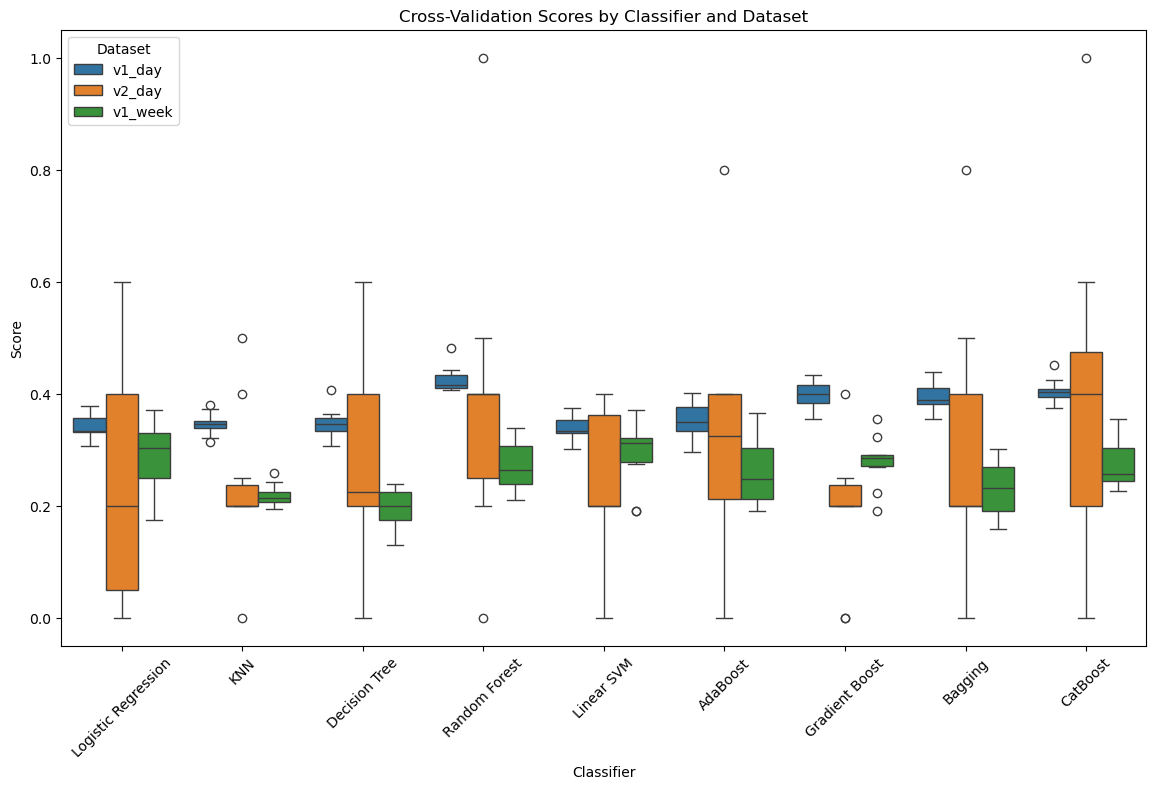

In [39]:
# Extract data to flattened df for plotting
flat_results = []

for dataset_name, clf_results in results.items():
    for clf_name, scores in clf_results.items():
        for score in scores:
            flat_results.append({
                'Dataset': dataset_name,
                'Classifier': clf_name,
                'Score': score
            })

results_df = pd.DataFrame(flat_results)

plt.figure(figsize=(14, 8))
sns.boxplot(x='Classifier', y='Score', hue='Dataset', data=results_df)
plt.xticks(rotation=45)
plt.title('Cross-Validation Scores by Classifier and Dataset')
plt.show()


## From this it seems that Cat Boost is doing the best.

From the table, we can see the best performing model was CatBoost, followed by Ada Boost. The worst performing model was the KNN.

Now we'll use a large area to sample the general best parameters.


In [ ]:
for name in df_names:
    print(f"--- Dataset: {name} ---")
    X_train_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_train.csv'))
    y_train_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_train.csv'))
    # test
    X_test_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_test.csv'))
    y_test_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_test.csv'))

    X_train = X_train_unclean.drop(columns=[col for col in X_train_unclean.columns if col in id_columns or 'Unnamed' in col])
    y_train = y_train_unclean.drop(columns=[col for col in y_train_unclean.columns if 'Unnamed' in col]).squeeze()
    X_test = X_test_unclean.drop(columns=[col for col in X_test_unclean.columns if col in id_columns or 'Unnamed' in col])
    y_test = y_test_unclean.drop(columns=[col for col in y_test_unclean.columns if 'Unnamed' in col]).squeeze()

    # Define parameter grid based on dataset
    if name == "v1_day":
        param_grid = {
                'iterations': [i for i in range(100, 200)],
                'learning_rate': [round(i, 10) for i in uniform.rvs(loc=0.15, scale=0.25, size=10)],
                'depth': [i for i in range(0, 15)],
                'l2_leaf_reg': [round(i, 10) for i in uniform.rvs(loc=7, scale=9, size=10)],
                'border_count': [i for i in range(0, 200)],
                'random_strength': [round(i, 10) for i in uniform.rvs(loc=0.4, scale=0.2, size=10)]
            }
    elif name == "v2_day":
        param_grid = {
                'iterations': [i for i in range(100, 200)],
                'learning_rate': [round(i, 10) for i in uniform.rvs(loc=0.15, scale=0.25, size=10)],
                'depth': [i for i in range(0, 15)],
                'l2_leaf_reg': [round(i, 10) for i in uniform.rvs(loc=7, scale=9, size=10)],
                'border_count': [i for i in range(0, 200)],
                'random_strength': [round(i, 10) for i in uniform.rvs(loc=0.4, scale=0.2, size=10)]
        }
    elif name == "v1_week":
        param_grid = {
                'iterations': [i for i in range(100, 200)],
                'learning_rate': [round(i, 10) for i in uniform.rvs(loc=0.15, scale=0.25, size=10)],
                'depth': [i for i in range(0, 15)],
                'l2_leaf_reg': [round(i, 10) for i in uniform.rvs(loc=7, scale=9, size=10)],
                'border_count': [i for i in range(0, 200)],
                'random_strength': [round(i, 10) for i in uniform.rvs(loc=0.4, scale=0.2, size=10)]
        }
    
    # Initialize the CatBoostClassifier
    model = CatBoostClassifier(random_state=42, verbose=0)

    # Perform grid search
    grid = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=100,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )

    # Log best results
    grid.fit(X_train, y_train)

    best_params = grid.best_params_

    final_model = CatBoostClassifier(**best_params, random_state=42)

    final_model.fit(X_train, y_train)
    score = final_model.score(X_test, y_test)

    results[name] = {
        "best_params": best_params,
        "best_score": score
        }

    # Save grid search results to a JSON file
    with open(f"{name}_catboost_randomsearch_results.json", "w") as f:
        json.dump(results, f, indent=4)




The best parameters for each model are saved into {name}_catboost_gridsearch_results.json. From this we've gotten the 'best parameters' found, as well as an accuracy score. We can use these accuracy scores to compare to the increases in accuracy from optimizing hyperparameters.


"v1_day": {
"best_params": {  
    "bagging_temperature": 0.3745,
    "border_count": 124,
    "depth": 9,
    "iterations": 156,
    "l2_leaf_reg": 8.7969,
    "learning_rate": 0.1891,
    "random_strength": 0.4458
},  
"best_score": 0.3882  

"v2_day": 
"best_params": {  
    "bagging_temperature": 0.9869,
    "border_count": 119,
    "depth": 3,
    "iterations": 285,
    "l2_leaf_reg": 3.9350,
    "learning_rate": 0.0142,
    "random_strength": 0.1988
},  
"best_score": 0.3224   

"v1_week":  
"best_params": {
    "bagging_temperature": 0.3590,
    "border_count": 158,
    "depth": 5,
    "iterations": 283,
    "l2_leaf_reg": 9.77374,
    "learning_rate": 0.2322,
    "random_strength": 0.6970
},  
"best_score": 0.2616  

## Increase random Search
From those parameter dicts we can make the parameter space smaller and more specifically find the optimal parameters for each aspect of the model. We'll use a random search still to decrease the compute time, but increase the iterations and decrease the ranges for each parameter.

We can then use the optimized hyperparameters and evaluate the accuracy score of the final model.

We'll use RMSE because we're interested in generally predicting the area of the depression score each subject is in.

In [ ]:
for name in df_names:
    print(f"--- Dataset: {name} ---")
    X_train_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_train.csv'))
    y_train_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_train.csv'))
    # test
    X_test_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_test.csv'))
    y_test_unclean = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_test.csv'))

    X_train = X_train_unclean.drop(columns=[col for col in X_train_unclean.columns if col in id_columns or 'Unnamed' in col])
    y_train = y_train_unclean.drop(columns=[col for col in y_train_unclean.columns if 'Unnamed' in col]).squeeze()
    X_test = X_test_unclean.drop(columns=[col for col in X_test_unclean.columns if col in id_columns or 'Unnamed' in col])
    y_test = y_test_unclean.drop(columns=[col for col in y_test_unclean.columns if 'Unnamed' in col]).squeeze()

    # Define parameter grid based on dataset
    if name == "v1_day":
        param_grid = {
                'iterations': [i for i in range(140, 170)],
                'learning_rate': [round(i, 3) for i in uniform.rvs(loc=0.15, scale=0.25, size=10)],
                'depth': [i for i in range(8, 12)],
                'l2_leaf_reg': [round(i, 3) for i in uniform.rvs(loc=7, scale=9, size=10)],
                'border_count': [i for i in range(110, 131)],
                'random_strength': [round(i, 3) for i in uniform.rvs(loc=0.4, scale=0.2, size=10)]
            }
    elif name == "v2_day":
        param_grid = {
            'iterations': [i for i in range(270, 296)],
            'learning_rate': [round(i, 5) for i in uniform.rvs(loc=0.01, scale=0.015, size=10)],
            'depth': [i for i in range(2, 6)],
            'l2_leaf_reg': [round(i, 3) for i in uniform.rvs(loc=3, scale=2, size=10)],
            'border_count': [i for i in range(110, 131)],
            'random_strength': [round(i, 3) for i in uniform.rvs(loc=0.1, scale=0.25, size=10)]
        }
    elif name == "v1_week":
        param_grid = {
            'iterations': [i for i in range(278, 296)],
            'learning_rate': [round(i, 3) for i in uniform.rvs(loc=0.18, scale=0.09, size=10)],
            'depth': [i for i in range(4, 8)],
            'l2_leaf_reg': [round(i, 3) for i in uniform.rvs(loc=9, scale=2, size=10)],
            'border_count': [i for i in range(150, 166)],
            'random_strength': [round(i, 3) for i in uniform.rvs(loc=0.58, scale=0.17, size=10)]
        }
    
    # Initialize the CatBoostClassifier
    model = CatBoostClassifier(random_state=42, verbose=0)

    # Perform grid search
    grid = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=100,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )

    # Log best results
    grid.fit(X_train, y_train)

    best_params = grid.best_params_
    results[name] = {"best_params": best_params}

    # Save grid search results to a JSON file
    with open(f"{name}_catboost_gridsearch_results.json", "w") as f:
        json.dump(results, f, indent=4)

    final_model = CatBoostClassifier(**best_params, random_state=42)

    final_model.fit(X_train, y_train)
    score = final_model.score(X_test, y_test)

    # Optionally, save predictions to a file
    with open(f"{name}_predictions.json", "w") as f:
        json.dump({"accuracy": score}, f, indent=4)

    print(f"{name} accuracy: {score:.4f}")



#### Increased random search results
Now we can see the best parameters for each dataset, as well as the accuracy over all crossfolds. 

v1_day_predictions.json:
{
    "accuracy": 0.4089
}  

v2_day_predictions.json:
{
    "accuracy": 0.3846
}  

v1_week_predictions.json:
{
    "accuracy": 0.33758
}


### Evaluating results
We can now see the accuracy of each loosely-optimized hyperparameter model and increased-optimized hyperparameter model. We compare the accuracies in this below chart: 

In [ ]:
results = {
    "optimized_model": {
        "v1_day": 0.4089, 
        "v2_day": 0.3846,
        "v1_week": 0.33758
    },
    "loose_model": {
        "v1_day": 0.3882,
        "v2_day": 0.3224,
        "v1_week": 0.2616
    }
}

results_df = pd.DataFrame(results).reset_index()

melted = results_df.melt(id_vars='index', value_vars=['optimized_model', 'loose_model'],
                      var_name='Model Type', value_name='accuracy_score')
melted=melted.sort_values('index')
fig = px.bar(melted, color='Model Type', x='index', y='accuracy_score',
             barmode='group', 
             title='Accuracy Score Change for Loose vs. Optimized Hyperparameters')
fig.show()


As we can see, optimizing the hyperparameters further did give us an increase in accuracy, though not a huge increase. For v1_day it increased about 2%, for v1_week it increased around 7% and for v2_day about 6%.

In [ ]:

# def crossvaltest(params,train_set,train_label,cat_dims,n_splits=3):
#     kf = KFold(n_splits=n_splits,shuffle=True) 
#     res = []
#     for train_index, test_index in kf.split(train_set):
#         train = train_set.iloc[train_index,:]
#         test = train_set.iloc[test_index,:]

#         labels = train_label.ix[train_index]
#         test_labels = train_label.ix[test_index]

#         clf = cb.CatBoostClassifier(**params)
#         clf.fit(train, np.ravel(labels), cat_features=cat_dims)

#         res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
#     return np.mean(res)


# # this function runs grid search on several parameters
# def catboost_param_tune(params,train_set,train_label,cat_dims=None,n_splits=3):
   

#     ps = paramsearch(params)
#     # search 'border_count', 'l2_leaf_reg' etc. individually 
#     #   but 'iterations','learning_rate' together
#     for prms in chain(ps.grid_search(['border_count']),
#                       ps.grid_search(['ctr_border_count']),
#                       ps.grid_search(['l2_leaf_reg']),
#                       ps.grid_search(['iterations','learning_rate']),
#                       ps.grid_search(['depth'])):
#         res = crossvaltest(prms,train_set,train_label,cat_dims,n_splits)
#         # save the crossvalidation result so that future iterations can reuse the best parameters
#         ps.register_result(res,prms)
#         print(res,prms,s'best:',ps.bestscore(),ps.bestparam())
#     return ps.bestparam()

# bestparams = catboost_param_tune(params,train_set,train_label,cat_dims)


### Bayesian Hyperparameter Optimization
This took over 9 hours and still didn't converge, so let's try another method. 

First we'll try to optimize hyperparameters for KNN.

In [30]:
from sklearn.metrics import accuracy_score
name = 'v1_day'
X_train_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_train.csv'))
X_train_cleaned = X_train_df.drop(columns=[col for col in X_train_df.columns if col in id_columns or 'Unnamed' in col])
y_train_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_train.csv'))
y_train_cleaned = y_train_df.drop(columns=[col for col in y_train_df.columns if 'Unnamed' in col]).squeeze()

X_test_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_X_test.csv'))
X_test_cleaned = X_test_df.drop(columns=[col for col in X_test_df.columns if col in id_columns or 'Unnamed' in col])
y_test_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_y_test.csv'))
y_test_cleaned = y_test_df.drop(columns=[col for col in y_test_df.columns if 'Unnamed' in col]).squeeze()

X_df = pd.concat([X_train_cleaned, X_test_cleaned], axis=0)
y_df = pd.concat([y_train_cleaned, y_test_cleaned], axis=0)

X = X_df.to_numpy()
y = y_df.to_numpy()
X_train = X_train_cleaned.to_numpy()
y_train = y_train_cleaned.to_numpy()
X_test = X_test_cleaned.to_numpy()
y_test = y_test_cleaned.to_numpy()


def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X, y).mean()

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1, 31)),  # 30 values
    'weights': hp.choice('weights', ['uniform', 'distance']),
    'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
    'leaf_size': hp.quniform('leaf_size', 10, 50, 1)
}

def f(params):
    clf = KNeighborsClassifier(
        n_neighbors=params['n_neighbors'],
        weights=params['weights'],
        algorithm=params['algorithm'],
        leaf_size=int(params['leaf_size'])
    )
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    return {'loss': -acc, 'status': STATUS_OK}
    # acc = cross_val_score(clf, X_train, y_train, cv=5).mean()  # Use cross-validation    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print(f'best: {best}')


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

job exception: ('switch argument was', 1)



  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


TypeError: ('switch argument was', 1)

In [ ]:
f, ax = plt.subplots(1)#, figsize=(10,10))
xs = [t['misc']['vals']['n'] for t in trials.trials]
ys = [-t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
ax.set_title('Iris Dataset - KNN', fontsize=18)
ax.set_xlabel('n_neighbors', fontsize=12)
ax.set_ylabel('cross validation accuracy', fontsize=12)

In [27]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
print(type(X))
y = iris.target
print(type(y))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
